In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import MicroTools as micro
from MicroTools import plot_tools as pt
import MiniTools as mini
import MicroTools.param_scan as param_scan

In [3]:
dic_osc_app = param_scan.load_scan_data('fit_data/MH_apponly.pkl')
dic_osc_full = param_scan.load_scan_data('fit_data/MH_numu_MC_keep_numu_norm.pkl')
dic_dec_full = param_scan.load_scan_data('fit_data/MH_decay_test_30.pkl')

bf_osc_app = param_scan.get_best_fit_point(dic_osc_app)
bf_osc_full = param_scan.get_best_fit_point(dic_osc_full)
bf_dec_full = param_scan.get_best_fit_point(dic_dec_full)

In [33]:
params_no_osc = {'g': 1e-10, 'Ue4Sq': 1e-10, 'Um4Sq': 1e-10, 'm4': 1}
rates_no_osc = param_scan.get_nue_rates(params_no_osc, oscillations=True, use_numu_MC=True, include_antineutrinos=True, decay=False, decouple_decay=False, disappearance=True, energy_degradation=True, n_replications=1, undo_numu_normalization=False)


params_BEST_osc = {'g': 1e-5, 'Ue4Sq': 0.1, 'Um4Sq': 1e-2, 'm4': 1}
params_BEST_dec = {'g': 1, 'Ue4Sq': 0.1, 'Um4Sq': 3e-3, 'm4': 1e3}
rates_dic_osc_BEST = param_scan.get_nue_rates(params_BEST_osc, oscillations=True, use_numu_MC=True, include_antineutrinos=True, decay=False, decouple_decay=False, disappearance=True, energy_degradation=True, n_replications=1, undo_numu_normalization=False)
rates_dic_decay_BEST = param_scan.get_nue_rates(params_BEST_dec, oscillations=True, use_numu_MC=True, include_antineutrinos=True, decay=True, decouple_decay=False, disappearance=True, energy_degradation=True, n_replications=10, undo_numu_normalization=False)

params_solar_osc = {'g': 1e-3, 'Ue4Sq': 0.05, 'Um4Sq': 2e-2, 'm4': 1}
params_solar_dec = {'g': 1, 'Ue4Sq': 0.05, 'Um4Sq': 3e-3, 'm4': 1e3}
rates_dic_osc_solar = param_scan.get_nue_rates(params_solar_osc, oscillations=True, use_numu_MC=True, include_antineutrinos=True, decay=False, decouple_decay=False, disappearance=True, energy_degradation=True, n_replications=1, undo_numu_normalization=False)
rates_dic_decay_solar = param_scan.get_nue_rates(params_solar_dec, oscillations=True, use_numu_MC=True, include_antineutrinos=True, decay=True, decouple_decay=False, disappearance=True, energy_degradation=True, n_replications=10, undo_numu_normalization=False)

rates_dic_bf_osc_full = param_scan.get_nue_rates(bf_osc_full, oscillations=True, use_numu_MC=True, include_antineutrinos=True, decay=False, decouple_decay=False, disappearance=True, energy_degradation=True, n_replications=1, undo_numu_normalization=False)
rates_dic_bf_dec_full = param_scan.get_nue_rates(bf_dec_full, oscillations=True, use_numu_MC=True, include_antineutrinos=True, decay=True, decouple_decay=False, disappearance=True, energy_degradation=True, n_replications=10, undo_numu_normalization=False)

In [34]:
from MicroTools.sterile_tools import Sterile

dic = {'g': 100, 'Ue4Sq': 0.5, 'Um4Sq': 0.00001, 'm4': 1000.0}
sterile = Sterile(
dic,
oscillations=True,
decay=True,
decouple_decay=False,
CP=+1,
)

# ells = np.linspace(0.8*micro.L_micro, 1.2*micro.L_micro)
# Eparent = 1.0
# Edaughter = np.linspace(0, Eparent, 10)

# plt.plot(Edaughter, sterile.Pee(Eparent, Edaughter, micro.L_micro))

In [40]:
params_hugeUe4_osc = {'g': 1e-10, 'Ue4Sq': 0.5, 'Um4Sq': 1e-6, 'm4': 1e3}
params_hugeUe4_dec = {'g': 10000, 'Ue4Sq': 0.5, 'Um4Sq': 1e-6, 'm4': 1e3}
params_medUe4_dec = {'g': 10000, 'Ue4Sq': 0.25, 'Um4Sq': 1e-6, 'm4': 1e3}
params_smallUe4_dec = {'g': 10000, 'Ue4Sq': 0.01, 'Um4Sq': 1e-6, 'm4': 1e3}
rates_dic_osc_hugeUe4 = param_scan.get_nue_rates(params_hugeUe4_osc, oscillations=True, use_numu_MC=True, include_antineutrinos=True, decay=False, decouple_decay=False, disappearance=True, energy_degradation=False, n_replications=1, undo_numu_normalization=False)
rates_dic_decay_hugeUe4 = param_scan.get_nue_rates(params_hugeUe4_dec, oscillations=True, use_numu_MC=True, include_antineutrinos=True, decay=True, decouple_decay=False, disappearance=True, energy_degradation=True, n_replications=10, undo_numu_normalization=False)
rates_dic_decay_medUe4 = param_scan.get_nue_rates(params_medUe4_dec, oscillations=True, use_numu_MC=True, include_antineutrinos=True, decay=True, decouple_decay=False, disappearance=True, energy_degradation=True, n_replications=10, undo_numu_normalization=False)
rates_dic_decay_smallUe4 = param_scan.get_nue_rates(params_smallUe4_dec, oscillations=True, use_numu_MC=True, include_antineutrinos=True, decay=True, decouple_decay=False, disappearance=True, energy_degradation=True, n_replications=10, undo_numu_normalization=False)


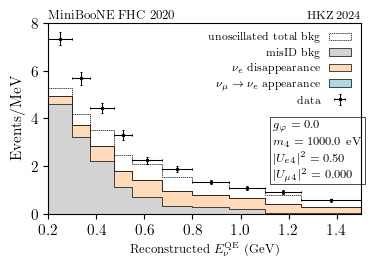

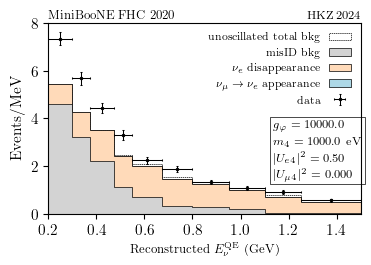

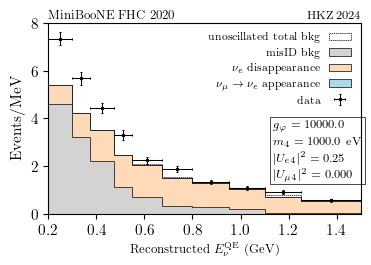

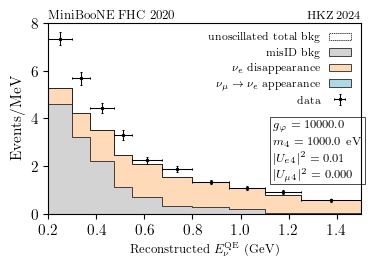

In [41]:
pt.make_rate_plot(rates_dic_osc_hugeUe4, params_hugeUe4_osc, '3+1_osc_hugeUe4')
pt.make_rate_plot(rates_dic_decay_hugeUe4, params_hugeUe4_dec, '3+1_dec_hugeUe4')
pt.make_rate_plot(rates_dic_decay_medUe4, params_medUe4_dec, '3+1_dec_medUe4')
pt.make_rate_plot(rates_dic_decay_smallUe4, params_smallUe4_dec, '3+1_dec_smallUe4')


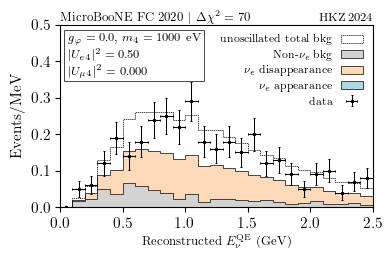

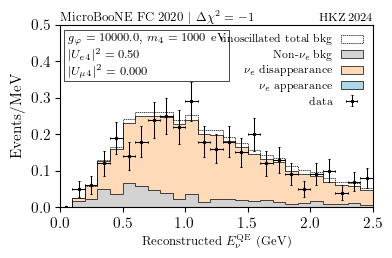

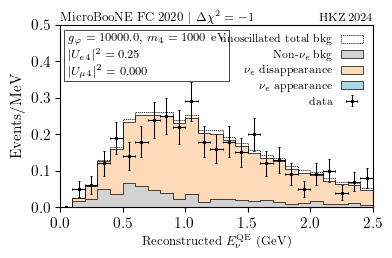

In [42]:
pt.make_micro_rate_plot(rates_dic_osc_hugeUe4, params_hugeUe4_osc, '3+1_osc_hugeUe4')
pt.make_micro_rate_plot(rates_dic_decay_hugeUe4, params_hugeUe4_dec, '3+1_dec_hugeUe4')
pt.make_micro_rate_plot(rates_dic_decay_medUe4, params_medUe4_dec, '3+1_dec_medUe4_nodeg')

## MiniBooNE nu_e sample

In [ ]:
import scipy


# import the necessary module
# define the chi-square probability
pval, pval_nu = mini.fit.get_pval(rates_dic_decay_solar, ndof=38 - 2), mini.fit.get_pval(rates_dic_decay_solar, ndof=38/2 - 1)

# calculate the number of standard deviations # NOTE: lazy... I can't remember how to relate the two....
# std_devs, std_devs_nu = np.sqrt(scipy.stats.chi2.ppf(1-pval, 38-2)), np.sqrt(scipy.stats.chi2.ppf(1-pval_nu, 38/2-1))

print(pval, pval_nu)

0.28280729290236456 0.0018523343697749073


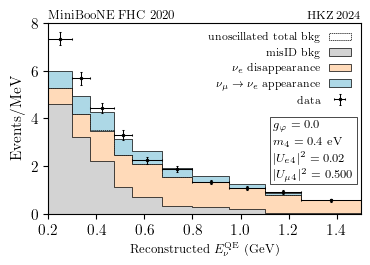

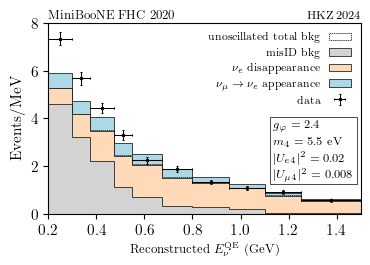

In [ ]:
pt.make_rate_plot(rates_dic_bf_osc_full, bf_osc_full, '3+1_osc_bf')
pt.make_rate_plot(rates_dic_bf_dec_full, bf_dec_full, '3+1_dec_bf')

# pt.make_numu_rate_plot(rates_dic_bf_osc_full, bf_osc_full, '3+1_osc_bf')
# pt.make_numu_rate_plot(rates_dic_bf_dec_full, bf_dec_full, '3+1_dec_bf')

# pt.make_micro_rate_plot(rates_dic_bf_osc_full, bf_osc_full, '3+1_osc_bf')
# pt.make_micro_rate_plot(rates_dic_bf_dec_full, bf_dec_full, '3+1_dec_bf')

# pt.make_micro_rate_plot(rates_dic_bf_osc_full, bf_osc_full, '3+1_osc_bf', PC=True)
# pt.make_micro_rate_plot(rates_dic_bf_dec_full, bf_dec_full, '3+1_dec_bf', PC=True)

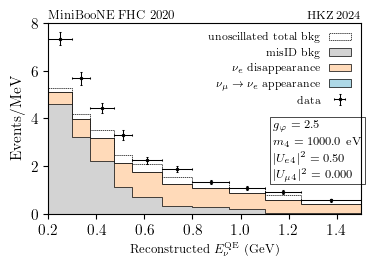

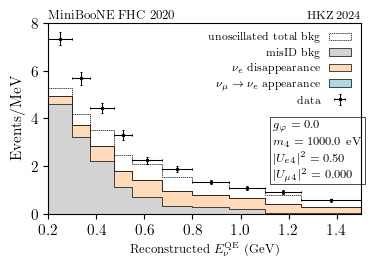

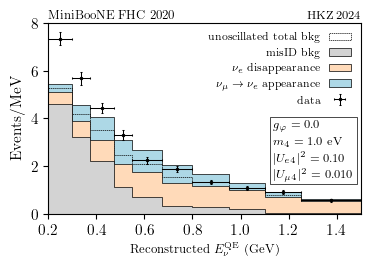

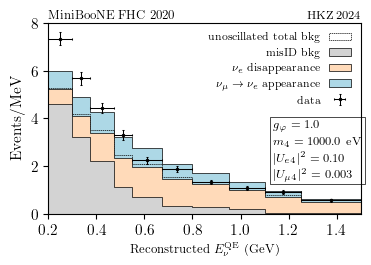

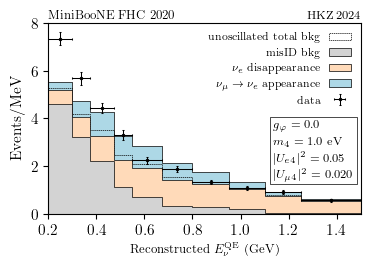

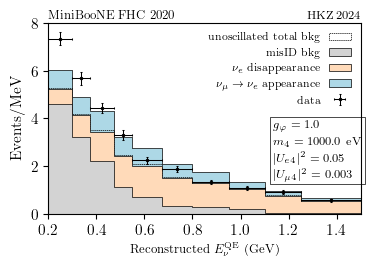

In [ ]:
pt.make_rate_plot(rates_dic_decay_hugeUe4, params_hugeUe4_dec, '3+1_dec_hugeUe4')
pt.make_rate_plot(rates_dic_osc_hugeUe4, params_hugeUe4_osc, '3+1_osc_hugeUe4')

pt.make_rate_plot(rates_dic_osc_BEST, params_BEST_osc, '3+1_osc_BEST')
pt.make_rate_plot(rates_dic_decay_BEST, params_BEST_dec, '3+1_dec_BEST')

pt.make_rate_plot(rates_dic_osc_solar, params_solar_osc, '3+1_osc_solar')
pt.make_rate_plot(rates_dic_decay_solar, params_solar_dec, '3+1_dec_solar')

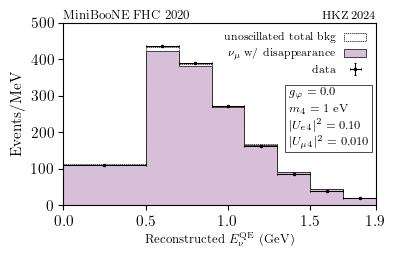

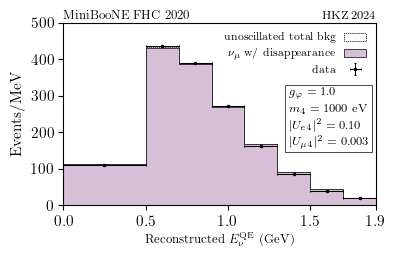

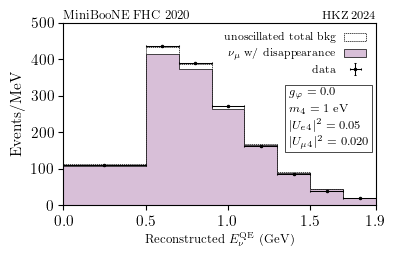

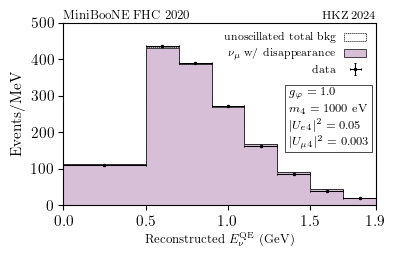

In [ ]:
pt.make_numu_rate_plot(rates_dic_osc_BEST, params_BEST_osc, '3+1_osc_BEST')
pt.make_numu_rate_plot(rates_dic_decay_BEST, params_BEST_dec, '3+1_dec_BEST')

pt.make_numu_rate_plot(rates_dic_osc_solar, params_solar_osc, '3+1_osc_solar')
pt.make_numu_rate_plot(rates_dic_decay_solar, params_solar_dec, '3+1_dec_solar')

## MicroBooNE Rates

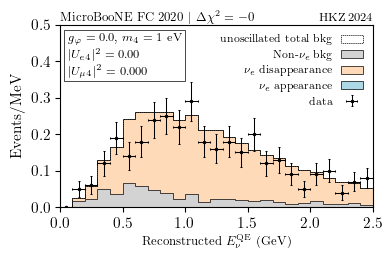

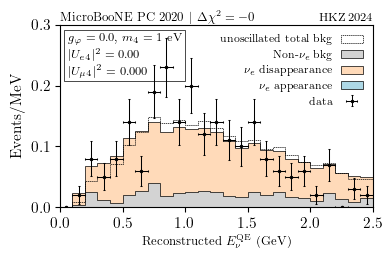

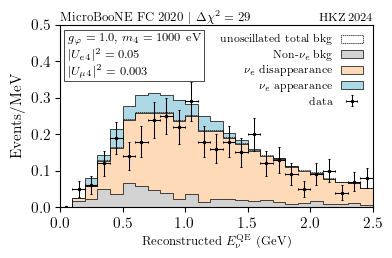

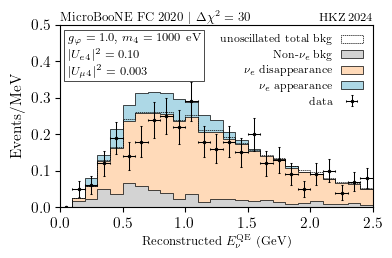

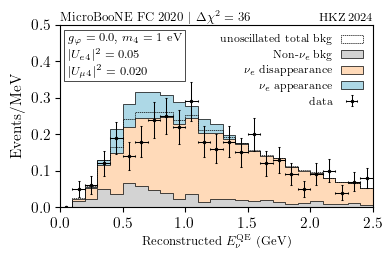

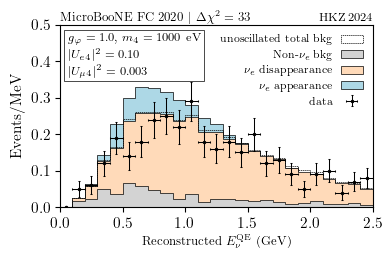

In [ ]:
pt.make_micro_rate_plot(rates_no_osc, params_no_osc, 'No osc')
pt.make_micro_rate_plot(rates_no_osc, params_no_osc, 'No osc', PC=True)

pt.make_micro_rate_plot(rates_dic_decay_solar, params_solar_dec, '3+1_dec_BEST')
# pt.make_micro_rate_plot(rates_dic_decay_solar, params_solar_dec, '3+1_dec_BEST', PC=True)

pt.make_micro_rate_plot(rates_dic_decay_BEST, params_BEST_dec, '3+1_dec_BEST')
# pt.make_micro_rate_plot(rates_dic_decay_BEST, params_BEST_dec, '3+1_dec_BEST', PC=True)

pt.make_micro_rate_plot(rates_dic_osc_solar, params_solar_osc, '3+1_osc_solar')
# pt.make_micro_rate_plot(rates_dic_osc_solar, params_solar_osc, '3+1_osc_solar', PC=True)

pt.make_micro_rate_plot(rates_dic_osc_BEST, params_BEST_dec, '3+1_osc_BEST')
# pt.make_micro_rate_plot(rates_dic_osc_BEST, params_BEST_dec, '3+1_osc_BEST', PC=True)